# Сборный проект-4

**Описание проекта:**

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.


## Описание данных

Данные лежат в папке `/datasets/image_search/` или доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле **`train_dataset.csv`** находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке **`train_images`** содержатся изображения для тренировки модели.

В файле **`CrowdAnnotations.tsv`** — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле **`ExpertAnnotations.tsv`** содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле **`test_queries.csv`** находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке **`test_images`** содержатся изображения для тестирования модели.

## Импорт библиотек и исходных данных.

**Импорт библиотек.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torchvision.models as models
import torch.nn as nn
from torchvision import transforms

from PIL import Image
import os

from tqdm import notebook
from tqdm import tqdm
from pprint import pprint
import time
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer, SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords as nltk_stopwords

import spacy
from spacy.lang.en.examples import sentences 

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import GroupShuffleSplit

import transformers 

from catboost import CatBoostRegressor, Pool

In [2]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
stop_words = list(stopwords.words('english'))



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/maksimgorskov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/maksimgorskov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maksimgorskov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Импорт исходных данных.**

In [3]:
#Для корректной работы кода необходимо заменить путь к директории на локальной машине, содержащей необходимыйе датасеты.
path = '/Users/maksimgorskov/Desktop/Data Science/Спринт 22_Сборочный проект/Source Data/'

#Загрузка датасета с разметкой данных от краудсорсинга.
crowd_ann_data = pd.read_csv(path + 'CrowdAnnotations.tsv', sep='\t', header=None)

#Загрузка датасета с разметкой данных от экспертов.
expert_ann_data = pd.read_csv(path + 'ExpertAnnotations.tsv', sep='\t', header=None)

#Загрузка тренировочного датасета.
train_data = pd.read_csv(path + 'train_dataset.csv')

#Загрузка тестовго датасета с изображениями.
test_img_data = pd.read_csv(path + 'test_images.csv')

#Загрузка тестовго датасета с списком изображений для теста. 
test_queries_data = pd.read_csv(path + 'test_queries.csv', sep='|', index_col = 0)

## Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


**Анализ экспертных оценок.**

In [4]:
expert_ann_data.head()

,0,1,2,3,4
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


In [5]:
expert_ann_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       5822 non-null   object
 1   1       5822 non-null   object
 2   2       5822 non-null   int64 
 3   3       5822 non-null   int64 
 4   4       5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


In [6]:
# Список из трех списков(каждый третий список - это список количества оценок от 1 до 4 для каждого эксперта).
#Индексация соответствует номерам экспертов и номерам оценок.
sum_list = []
for n in range(2, 5):
    i_list = []
    for i in expert_ann_data[n].unique():
        i_mark = expert_ann_data[expert_ann_data[n] == i][n].count()
        i_list.append(i_mark)
    sum_list.append(i_list)
print(sum_list)

[[4120, 1109, 346, 247], [3327, 1666, 518, 311], [2350, 2222, 837, 413]]


In [7]:
indx_0 = [sublist[0] for sublist in sum_list if sublist]
indx_0

[4120, 3327, 2350]

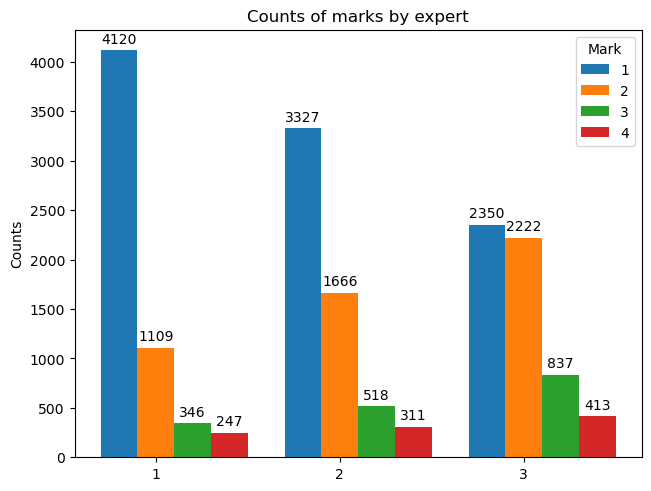

In [8]:
experts = ("1", "2", "3")
marks_means = {
    '1': [sublist[0] for sublist in sum_list if sublist],
    '2': [sublist[1] for sublist in sum_list if sublist],
    '3': [sublist[2] for sublist in sum_list if sublist],
    '4': [sublist[3] for sublist in sum_list if sublist]
}

x = np.arange(len(experts))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in marks_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Counts')
ax.set_title('Counts of marks by expert')
ax.set_xticks(x + width, experts)
ax.legend(title='Mark')


plt.show()

**Вывод:**
Из гистограммы распределение меток в зависимости от эксперта видно, что 3й эксперт размечает данные более сбалансированно, а 1-й 70% данных размечает как полностью не соответствущие действительности.

**Гипотеза:**
3-й эксперт размечает данные более вдумчиво. Правильность его ответов - лучше. 2-й эксперт размечает данные чуть лучше. 1-й - хуже всех. 

(Гипотеза касается лищь данных с оцеками 1 и 2)


Исходя из гипотезы, формирование общей оценки корреляции фотографии и комментария к ней возможно сформировать по принципу взвешенного среднего для определения общей вероятности.

- Эксперт 1: оценка вероятности p1 с весом w1 = 0.2
- Эксперт 2: оценка вероятности p2 с весом w2 = 0.3
- Эксперт 3: оценка вероятности p3 с весом w3 = 0.5

In [9]:
#Определение весов взвешенного среднего для определения общей вероятности. 
w_1 = 0.2
w_2 = 0.3
w_3 = 0.5

В задании необходимо определнить вероятности совпадения картинки и описания. Для этого все имеющиеся данные будут размечены как вероятности корреляции.

In [10]:
for column in (2, 3, 4):
    for i in range(1, 5):
        expert_ann_data.loc[expert_ann_data[column] == i, column] = expert_ann_data.loc[expert_ann_data[column] == i, column] / 4

**Анализ краудсорсинговых оценок.**

In [11]:
crowd_ann_data

,0,1,2,3,4
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.000000,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.000000,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.000000,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.000000,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.000000,0,3
...,...,...,...,...,...
47825,997722733_0cb5439472.jpg,543007912_23fc735b99.jpg#2,0.000000,0,3
47826,997722733_0cb5439472.jpg,544576742_283b65fa0d.jpg#2,0.333333,1,2
47827,997722733_0cb5439472.jpg,872622575_ba1d3632cc.jpg#2,1.000000,3,0
47828,997722733_0cb5439472.jpg,888425986_e4b6c12324.jpg#2,0.000000,0,3


In [12]:
crowd_ann_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       47830 non-null  object 
 1   1       47830 non-null  object 
 2   2       47830 non-null  float64
 3   3       47830 non-null  int64  
 4   4       47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [13]:
crowd_ann_data[5] = crowd_ann_data[3] + crowd_ann_data[4]
crowd_ann_data.describe()

,2,3,4,5
count,47830.000000,47830.000000,47830.000000,47830.000000
mean,0.068786,0.208488,2.820155,3.028643
std,0.207532,0.628898,0.656676,0.208075
min,0.000000,0.000000,0.000000,3.000000
25%,0.000000,0.000000,3.000000,3.000000
50%,0.000000,0.000000,3.000000,3.000000
75%,0.000000,0.000000,3.000000,3.000000
max,1.000000,5.000000,6.000000,6.000000


In [14]:
crowd_ann_data[2].value_counts()

2
0.000000    41970
0.333333     3000
0.666667     1360
1.000000     1323
0.250000       96
0.500000       27
0.200000       22
0.750000        9
0.600000        8
0.400000        8
0.800000        4
0.166667        3
Name: count, dtype: int64

В данных наблюдается сильный дисбаланс данных в сторону 0.

**Объеденение данных.**

Данных с разметкой от краудсорсинга в 8 раз больше, чем от экспертов. Поэтому стоит рассматривать метки от экспертов лишь как частичное дополнение данных с лучшим качеством.

Данные от экспертов и от краудсорсинга могут не совпадать. Поэтому два датасета сливаются методом outer с помощью функциии merge().

In [15]:
full_data = pd.merge(expert_ann_data, crowd_ann_data, on=[0, 1], how='outer')
full_data.head()

,0,1,2_x,3_x,4_x,2_y,3_y,4_y,5
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.25,0.25,0.25,0.0,0.0,3.0,3.0
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.25,0.25,0.50,0.0,0.0,3.0,3.0
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.25,0.25,0.50,NaN,NaN,NaN,NaN
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.25,0.50,0.50,NaN,NaN,NaN,NaN
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.25,0.25,0.50,NaN,NaN,NaN,NaN


Из общего набора данных видно, что размеченные данные можно разделить на 3 группы. 
- 1-я группа: есть разметка и от экспертов и от краудсорсинга;
- 2-я группа: есть разметка только от краудсорсинга;
- 3-я группа: есть разметка только от экспертов.

**Определение вероятности полной корреляции изображения и описания к нему.**

Для учета разметок данных и от краудсорсинга и от экспертов все пропуски заменяются на 0, а вес для взвешенного среднего от краудсорсинга принимается равным:
- w_0=0.1

Данное решение будет немного занижать значение предсказаний 2-й и 3-й групп.

In [16]:
full_data = full_data.fillna(0)
full_data.head()

,0,1,2_x,3_x,4_x,2_y,3_y,4_y,5
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.25,0.25,0.25,0.0,0.0,3.0,3.0
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.25,0.25,0.50,0.0,0.0,3.0,3.0
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.25,0.25,0.50,0.0,0.0,0.0,0.0
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.25,0.50,0.50,0.0,0.0,0.0,0.0
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.25,0.25,0.50,0.0,0.0,0.0,0.0


In [17]:
#Определение весов взвешенного среднего для определения общей вероятности. 
w_0 = 0.1

In [18]:
#Функция для определения общей вероятности совпадения описания и картинки на основании разметки экспертов.
def proba_pict (row):

    proba = (row['2_x'] * w_1 + row['3_x']*w_2 + row['4_x']*w_3 + row['2_y']*w_0) / (w_1 + w_2 + w_3 + w_0)
    proba=round(proba, 2)
    return proba


In [19]:
full_data['overal_proba'] = full_data.apply(proba_pict, axis = 1)
full_data['overal_proba'].unique()

array([0.23, 0.34, 0.41, 0.45, 0.52, 0.67, 0.57, 0.64, 0.6 , 0.68, 0.78,
       0.97, 0.75, 0.95, 1.  , 0.77, 0.63, 0.48, 0.8 , 0.89, 0.74, 0.37,
       0.44, 0.7 , 0.71, 0.83, 0.59, 0.81, 0.86, 0.84, 0.58, 0.55, 0.94,
       0.66, 0.92, 0.73, 0.91, 0.72, 0.85, 0.47, 0.62, 0.65, 0.5 , 0.87,
       0.26, 0.43, 0.88, 0.61, 0.36, 0.09, 0.  , 0.03, 0.06, 0.02, 0.05,
       0.04, 0.07])

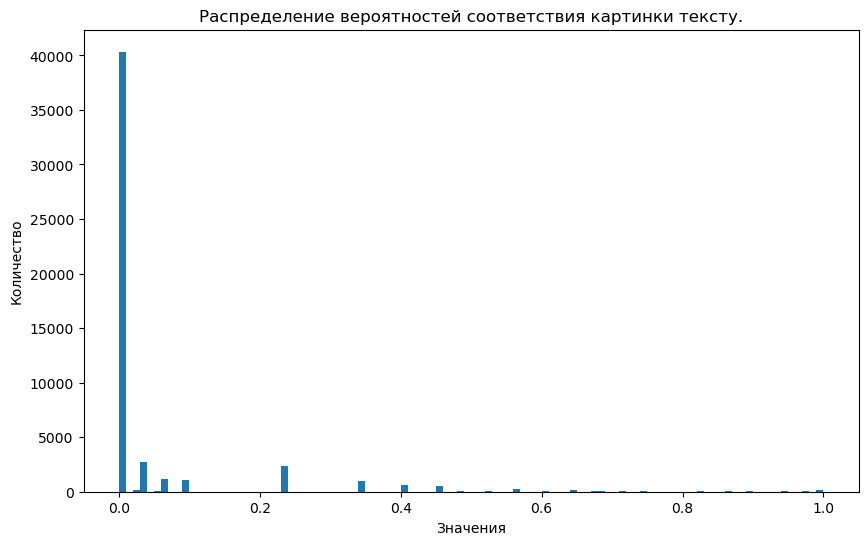

In [20]:
# Построение гистограммы распределения вероятностей.
plt.figure(figsize=(10, 6))  # Установим размер фигуры
plt.hist(full_data['overal_proba'], bins = 100)
plt.title('Распределение вероятностей соответствия картинки тексту.')
plt.xlabel('Значения')  # Подпись оси X
plt.ylabel('Количество')  # Подпись оси Y
plt.show()


In [21]:
full_data = full_data[[0, 1, 'overal_proba']]
full_data.head()

,0,1,overal_proba
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.23
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.34
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.34
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.41
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.34


<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментария студента</b></font>
   
На первый взгляд мы имеем задачу классификации - необходимо предсказать соответствует ли описание изображению или нет. Вероятность моджет быть определена методом predict_proba() в задаче классификации. Из этого суждения следует сформировать два класса в целевом признаке и решать задачу классификации.
    
Однако на данном шаге, я делаю предположение о том, что целевой признак лучше оставить дробным значением, которое будет показывать вероятность соотвтетствия картинки и изображения. После чего на базе обученных вероятностей, делать предсказания вероятностей на тестовой выборке. Ниже будет решаться задача регрессии.

**Вывод:**
Данные преобразованы в соответсвтии с заданием. Для каждой пары изображение-описание рассчитана вероятность правильного мэтчинга.

Также в данных наблюдается сильный дисбаланс в сторону описаний, которые полностью не соответствуют изображениям, и имеют вероятность 0.

## Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

Для выполнени этого требования данные проходят по следующему фильтру:
Если в описании к изображению есть ключевые слова из списка child_key_words, то данные позиции не учитываются в датафрейме.

In [22]:
train_data

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
...,...,...,...
5817,757046028_ff5999f91b.jpg,2061144717_5b3a1864f0.jpg#2,A man in an ampitheater talking to a boy .
5818,799486353_f665d7b0f0.jpg,2196107384_361d73a170.jpg#2,a old man walks down the uncrowded road .
5819,909808296_23c427022d.jpg,2112921744_92bf706805.jpg#2,A dog stands on the side of a grassy cliff .
5820,929679367_ff8c7df2ee.jpg,3651971126_309e6a5e22.jpg#2,A blurry photo of two dogs .


In [23]:
child_key_words = [
    'child', 'boy', 'girl', 'pupil',
    'kid','schoolboy', 'schoolgirl',  
    'kindergarten', 'nursery', 'preschool', 
    'youngster'
]

In [24]:
def child_photo(row):
    for i in child_key_words:
        if i in row['query_text']:
            return 'high probability'

In [25]:
train_data['child_proba'] = train_data.apply(child_photo, axis = 1)


In [26]:
train_data['child_proba'].value_counts()

child_proba
high probability    1431
Name: count, dtype: int64

В соответствии с законодательством, 25% данных должно быть удалено.

In [27]:
train_data = train_data[train_data['child_proba'] != 'high probability']
train_data = train_data[['image', 'query_id', 'query_text']]
train_data.head()

,image,query_id,query_text
22,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .
23,3187395715_f2940c2b72.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .
24,463978865_c87c6ca84c.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .
25,488590040_35a3e96c89.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .
26,534875358_6ea30d3091.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .


**Вывод:** Обучающие данные с изображением детей исключены из датасета.

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментария студента</b></font>
   
Это самый простой и интуитивный способо, который можно предложить. Однако из предыдущего спринта у меня уже есть обученная модель, способная определять возраст людей. Имеет ли смысл встроить в модель - другую модель, чтобы отсеить фотографии детей из датасета? Или отдельно возможно даже прогнать ланные, которые у меня есть, через уже сузествующу. модель и сюда их выгрузить?

## Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [28]:
#Загрузка претренировочной модели
resnet = models.resnet18(pretrained=True)

/Users/maksimgorskov/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/maksimgorskov/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
for param in resnet.parameters():
    param.requires_grad_(False) 

In [30]:
print(list(resnet.children())) 

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(inplace=True), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False), Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

In [31]:
modules = list(resnet.children())[:-2]
resnet = nn.Sequential(*modules) 

In [32]:
resnet.eval() 

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [33]:
norm = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    norm,
]) 

In [34]:
#Данные должны находиться в локальной папке "train_images" внутри общей директории, указанной в разделе с импортами.
img_folder = path + 'train_images'

#Функция для эмбединга одного изображения. 
def img_emb(row):

    img_name=row['image']
    img_path = os.path.join(img_folder, img_name)
    img = Image.open(img_path).convert('RGB') 
    
    image_tensor = preprocess(img).unsqueeze(0)
    output_tensor = resnet(image_tensor).flatten() #Тензор спрямляется в вектор
    return output_tensor

In [35]:
train_data['embeding'] = train_data.apply(img_emb, axis=1)

In [36]:
train_data['embeding']

22      [tensor(1.4565), tensor(1.4630), tensor(0.0038...
23      [tensor(0.), tensor(0.), tensor(0.), tensor(0....
24      [tensor(2.4619), tensor(5.0047), tensor(5.3163...
25      [tensor(0.1198), tensor(1.9786), tensor(2.7893...
26      [tensor(0.), tensor(0.), tensor(0.), tensor(0....
                              ...                        
5816    [tensor(0.), tensor(0.), tensor(0.), tensor(0....
5818    [tensor(0.), tensor(0.), tensor(0.), tensor(0....
5819    [tensor(0.), tensor(0.), tensor(0.2197), tenso...
5820    [tensor(0.), tensor(0.), tensor(0.), tensor(0....
5821    [tensor(0.0535), tensor(0.3369), tensor(0.4606...
Name: embeding, Length: 4391, dtype: object

**Вывод:**

В тренировочный датасет добавлен ветор изображений.

## Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


### Лемметизация текстов

In [37]:
#Функция для чистки текста от лишних символов.
def text_preprocessing(text):
    tokenized = nltk.word_tokenize(text)
    joined = ' '.join(tokenized)
    text_only = re.sub(r"[^a-z0-9!@#\$%\^\&\*_\-,\.' ]", ' ', joined)
    final = ' '.join(text_only.split())
    return final

In [38]:
tqdm.pandas()
#Применение функции очистки к фрему данных.
train_data['query_text'] = train_data['query_text'].progress_apply(text_preprocessing)

100%|████████████████████████████████████| 4391/4391 [00:00<00:00, 26578.14it/s]


In [39]:
#Инициализация модели NLP
nlp = spacy.load('en_core_web_sm')
#, exclude=['parser', 'attribute_ruler', 'ner']

In [40]:
#Функция для лемматизации текстов.
def lemmatize(text):
    doc = nlp(text)
    words = []
    for token in doc:
        if (token.is_stop != True) and (token.is_punct != True) and\
            (token.is_space != True) and (token.is_digit != True):
            words.append(token.lemma_)
    return ' '.join(words)

In [41]:
#Лемметизация текста
tqdm.pandas()
train_data['query_text'] = train_data['query_text'].progress_apply(lemmatize)

100%|██████████████████████████████████████| 4391/4391 [00:10<00:00, 402.88it/s]


## Объединение разметочных данных с тренировочной выборкой.

В данном разделе к тренировочному датасету train_data присоединяются вероятности соответствия изображения и комментария к нему из датасета full_data.

Для уоректного объединения данных в датафрейме full_data необходимо заменить наименования столбцов '0' и '1' на 'image' и 'query_id' соответственно.

In [42]:
train_data

,image,query_id,query_text,embeding
22,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,man sleep blanket city street,"[tensor(1.4565), tensor(1.4630), tensor(0.0038..."
23,3187395715_f2940c2b72.jpg,3181701312_70a379ab6e.jpg#2,man sleep blanket city street,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
24,463978865_c87c6ca84c.jpg,3181701312_70a379ab6e.jpg#2,man sleep blanket city street,"[tensor(2.4619), tensor(5.0047), tensor(5.3163..."
25,488590040_35a3e96c89.jpg,3181701312_70a379ab6e.jpg#2,man sleep blanket city street,"[tensor(0.1198), tensor(1.9786), tensor(2.7893..."
26,534875358_6ea30d3091.jpg,3181701312_70a379ab6e.jpg#2,man sleep blanket city street,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
...,...,...,...,...
5816,799486353_f665d7b0f0.jpg,2170222061_e8bce4a32d.jpg#2,small animal leap large animal large animal ta...,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
5818,799486353_f665d7b0f0.jpg,2196107384_361d73a170.jpg#2,old man walk uncrowded road,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
5819,909808296_23c427022d.jpg,2112921744_92bf706805.jpg#2,dog stand grassy cliff,"[tensor(0.), tensor(0.), tensor(0.2197), tenso..."
5820,929679367_ff8c7df2ee.jpg,3651971126_309e6a5e22.jpg#2,blurry photo dog,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."


In [43]:
full_data = full_data.rename(columns={0:'image', 1: 'query_id'})

In [44]:
train_data_full = pd.merge(train_data, full_data, on=['image', 'query_id'], how='left')
train_data_full

,image,query_id,query_text,embeding,overal_proba
0,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,man sleep blanket city street,"[tensor(1.4565), tensor(1.4630), tensor(0.0038...",0.34
1,3187395715_f2940c2b72.jpg,3181701312_70a379ab6e.jpg#2,man sleep blanket city street,"[tensor(0.), tensor(0.), tensor(0.), tensor(0....",0.41
2,463978865_c87c6ca84c.jpg,3181701312_70a379ab6e.jpg#2,man sleep blanket city street,"[tensor(2.4619), tensor(5.0047), tensor(5.3163...",0.45
3,488590040_35a3e96c89.jpg,3181701312_70a379ab6e.jpg#2,man sleep blanket city street,"[tensor(0.1198), tensor(1.9786), tensor(2.7893...",0.41
4,534875358_6ea30d3091.jpg,3181701312_70a379ab6e.jpg#2,man sleep blanket city street,"[tensor(0.), tensor(0.), tensor(0.), tensor(0....",0.34
...,...,...,...,...,...
4386,799486353_f665d7b0f0.jpg,2170222061_e8bce4a32d.jpg#2,small animal leap large animal large animal ta...,"[tensor(0.), tensor(0.), tensor(0.), tensor(0....",0.23
4387,799486353_f665d7b0f0.jpg,2196107384_361d73a170.jpg#2,old man walk uncrowded road,"[tensor(0.), tensor(0.), tensor(0.), tensor(0....",0.23
4388,909808296_23c427022d.jpg,2112921744_92bf706805.jpg#2,dog stand grassy cliff,"[tensor(0.), tensor(0.), tensor(0.2197), tenso...",0.45
4389,929679367_ff8c7df2ee.jpg,3651971126_309e6a5e22.jpg#2,blurry photo dog,"[tensor(0.), tensor(0.), tensor(0.), tensor(0....",0.64


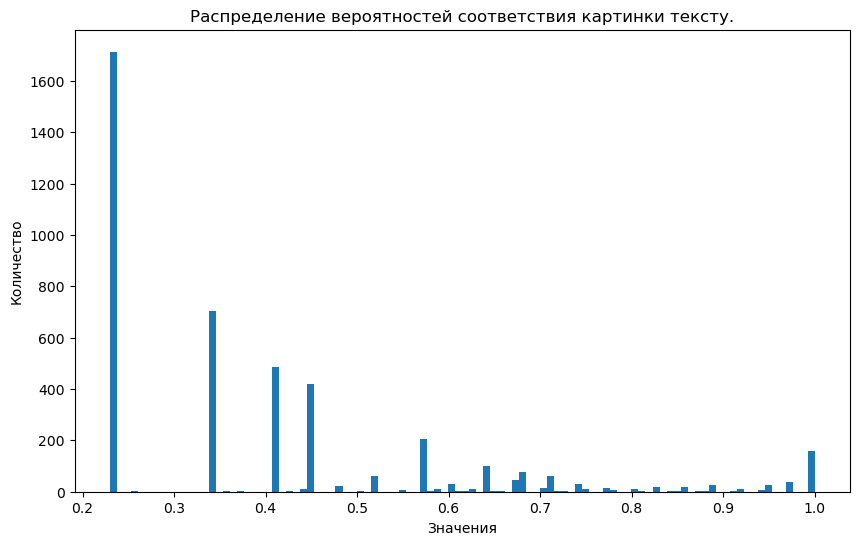

In [45]:
# Построение гистограммы распределения вероятностей.
plt.figure(figsize=(10, 6))  # Установим размер фигуры
plt.hist(train_data_full['overal_proba'], bins = 100)
plt.title('Распределение вероятностей соответствия картинки тексту.')
plt.xlabel('Значения')  # Подпись оси X
plt.ylabel('Количество')  # Подпись оси Y
plt.show()


**Вывод:**

В тренирововчном датасете к каждой паре изображение - описание к изображению присвоены вероятности, которые показывают, насколько два параметра соответствуют друг-другу.
В тренировочном датасете видно, что даннные распределены более равномерно, чем разметочные данные от экспертов и краудсорсинга.

## Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.


Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```
**Определение метрики:**
Основная цель — оценить, насколько хорошо модель способна определить соответствие между текстом и изображением, тогда можно использовать следующую метрику:
- Mean Absolute Error (MAE): Это среднее значение абсолютных разностей между фактическими и прогнозируемыми значениями. MAE измеряет среднее абсолютное отклонение прогнозируемых значений от фактических значений.

### Подготовка признаков

Определение целевого признака и набора фичей.

In [46]:
X = train_data_full.drop('overal_proba', axis=1)
y = train_data_full['overal_proba']

Разбиение на тестовую и валидационную выборки. Размер тестовой выборки = 70%, размер валидационной выборки - 30%.

In [47]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, valid_indices = next(gss.split(X=X, 
                                             y=y, 
                                             groups=train_data_full['image']))
                                  
train_df, valid_df = train_data_full.loc[train_indices], train_data_full.loc[valid_indices]


In [48]:
# Отдельное выделение признаков и целевой переменной из обучающей и валидационной выборок
X_train, y_train = train_df.drop(columns=['overal_proba']), train_df['overal_proba']
X_valid, y_valid = valid_df.drop(columns=['overal_proba']), valid_df['overal_proba']

# Проверка размерностей выборок
print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_valid.shape, y_valid.shape)

Train shape: (3066, 4) (3066,)
Validation shape: (1325, 4) (1325,)


**Вывод:**

Выборки разделены в правильном соотношении. Утечка данных из обучающей выборки исключена.

### TF-IDF

In [49]:
#Создание корпуса текстов. Добавление признаков в тестовую выборку.
corpus = X_train['query_text'].values
count_tf_idf = TfidfVectorizer(stop_words=stop_words)
X_train = count_tf_idf.fit_transform(corpus) 
print(f'Размер матрицы для обучения: {X_train.shape}')

Размер матрицы для обучения: (3066, 922)


In [50]:
#Создание корпуса текстов. Добавление признаков в валидационную выборку выборку.
corpus = X_valid['query_text'].values
X_valid = count_tf_idf.transform(corpus) 
print(f'Размер матрицы для обучения: {X_valid.shape}')

Размер матрицы для обучения: (1325, 922)


### CatBoostRegressor

In [51]:
#Функция для обучения модели CatBoostRegressor
def fit_model(train_pool, test_pool, **kwargs):
    model = CatBoostRegressor(
        iterations=5000,
        eval_metric='MAE',
        od_type='Iter',
        od_wait=500,
        l2_leaf_reg=2,
        border_count=32,
        depth=5,
        random_state=42,
        boosting_type='Plain',
        **kwargs
    )
    return model.fit(
        train_pool,
        eval_set=test_pool,
        verbose=500,
        use_best_model=True)

In [52]:
# Создание объекта Pool для обучения
train_pool = Pool(
    data=X_train,
    label=y_train
)

# Создание объекта Pool для теста
valid_pool = Pool(
    data=X_valid,
    label=y_valid
)

In [53]:
%%time
start_time = time.time()

model_cbc = fit_model(
    train_pool, valid_pool,
    learning_rate=0.001,
    tokenizers=[
        {
            'tokenizer_id': 'Sense',
            'separator_type': 'BySense',
            'lowercasing': 'True',
            'token_types':['Word', 'Number', 'SentenceBreak'],
            'sub_tokens_policy':'SeveralTokens'
        }      
    ],
    dictionaries = [
        {
            'dictionary_id': 'Word',
            'max_dictionary_size': '50000'
        }
    ],
    feature_calcers = [
        'BoW:top_tokens_count=10000'
    ]
)

end_time = time.time()
model_1_time = round(end_time - start_time, 0)

0:	learn: 0.1609513	test: 0.1625047	best: 0.1625047 (0)	total: 57.3ms	remaining: 4m 46s
500:	learn: 0.1581947	test: 0.1601857	best: 0.1601857 (500)	total: 634ms	remaining: 5.69s
1000:	learn: 0.1565082	test: 0.1588687	best: 0.1588687 (1000)	total: 1.2s	remaining: 4.81s
1500:	learn: 0.1554568	test: 0.1582279	best: 0.1582279 (1500)	total: 1.78s	remaining: 4.14s
2000:	learn: 0.1546216	test: 0.1578312	best: 0.1578312 (2000)	total: 2.35s	remaining: 3.52s
2500:	learn: 0.1539350	test: 0.1575252	best: 0.1575250 (2499)	total: 2.92s	remaining: 2.92s
3000:	learn: 0.1533295	test: 0.1572945	best: 0.1572945 (3000)	total: 3.5s	remaining: 2.33s
3500:	learn: 0.1527822	test: 0.1571134	best: 0.1571125 (3494)	total: 4.07s	remaining: 1.74s
4000:	learn: 0.1522779	test: 0.1569635	best: 0.1569635 (4000)	total: 4.64s	remaining: 1.16s
4500:	learn: 0.1518110	test: 0.1568418	best: 0.1568418 (4500)	total: 5.22s	remaining: 579ms
4999:	learn: 0.1513969	test: 0.1567446	best: 0.1567434 (4960)	total: 5.8s	remaining: 0us

**Вывод:**
На тестовой выборке абсолютное отклонение от вероятности соответствия картинки с текстом составляет 15,6%.

## Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

Описание методики определения картинки по запросу:

1) На базе 10 рандомных запросов и на базе датасета test_queries_data создается новый набор данных. Формирование датасета осуществляется следующим образом:
- Для кадого униканльгого изображения из датасета test_queries_data присваивается один и тот же запрос из спсика рандомных запросов.
- Данная опирация повторяется 10 раз.

2) Производится предобработка полученного датасета.

3) На основании ранее обучнной модели делается прогноз о вероятности корреляций изображений и описаний к ним.

4) Для каждого запроса выводится наиболее релевантное изображение. На основании вероятностей совпадений.


#### Формирование тестового датасета.

In [54]:
#Определение 10 рандомных запросов.
random_rows = test_queries_data.sample(n=10, random_state=42)['query_text']
random_rows = random_rows.reset_index(drop = True)

In [55]:
random_rows[0]

'A group of girls who are gothically dressed standing together'

In [56]:
test_values = pd.DataFrame(columns = ['image', 'requests'])
for i in random_rows:
    temp_df=pd.DataFrame()
    temp_df['image'] = test_queries_data['image'].unique()
    temp_df['requests'] = i
    test_values = pd.concat([test_values, temp_df], ignore_index=True)

In [57]:
test_values.head()

,image,requests
0,1177994172_10d143cb8d.jpg,A group of girls who are gothically dressed st...
1,1232148178_4f45cc3284.jpg,A group of girls who are gothically dressed st...
2,123997871_6a9ca987b1.jpg,A group of girls who are gothically dressed st...
3,1319634306_816f21677f.jpg,A group of girls who are gothically dressed st...
4,1429546659_44cb09cbe2.jpg,A group of girls who are gothically dressed st...


Датафрейм готов к предобработке.

### Подготовка тестовой выборки.

#### Получение эмбедингов изображений.

Для получения эмбедингов изображений используется функция **img_emb**

In [58]:
#Перезапись пути для тестовых изображений для корректной работы функци.
img_folder = path + 'test_images'

In [59]:
test_values['embeding'] = test_values.apply(img_emb, axis=1)

In [60]:
test_values.head()

,image,requests,embeding
0,1177994172_10d143cb8d.jpg,A group of girls who are gothically dressed st...,"[tensor(0.4101), tensor(0.4835), tensor(1.8883..."
1,1232148178_4f45cc3284.jpg,A group of girls who are gothically dressed st...,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
2,123997871_6a9ca987b1.jpg,A group of girls who are gothically dressed st...,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
3,1319634306_816f21677f.jpg,A group of girls who are gothically dressed st...,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
4,1429546659_44cb09cbe2.jpg,A group of girls who are gothically dressed st...,"[tensor(0.), tensor(1.3871), tensor(0.), tenso..."


#### Лемметизация текстов.

Чистка текста от лишних символов.

In [63]:
tqdm.pandas()
#Применение функции очистки к фрейму данных.
test_values['requests'] = test_values['requests'].progress_apply(text_preprocessing)

100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 16950.31it/s]


Лемметизация текстов.

In [64]:
#Лемметизация текста
tqdm.pandas()
test_values['requests'] = test_values['requests'].progress_apply(lemmatize)

100%|██████████████████████████████████████| 1000/1000 [00:02<00:00, 431.90it/s]


In [65]:
test_values.head()

,image,requests,embeding
0,1177994172_10d143cb8d.jpg,group girl gothically dress stand,"[tensor(0.4101), tensor(0.4835), tensor(1.8883..."
1,1232148178_4f45cc3284.jpg,group girl gothically dress stand,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
2,123997871_6a9ca987b1.jpg,group girl gothically dress stand,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
3,1319634306_816f21677f.jpg,group girl gothically dress stand,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
4,1429546659_44cb09cbe2.jpg,group girl gothically dress stand,"[tensor(0.), tensor(1.3871), tensor(0.), tenso..."


#### TF-IDF.

In [66]:
#Создание копии датафрейма test_queries_data для дальнейшего добавления предсказания вероятностей.
test_values_res = test_values.copy()

In [67]:
#Создание корпуса текстов. Добавление признаков в валидационную выборку выборку.
corpus = test_values['requests'].values
test_values = count_tf_idf.transform(corpus) 
print(f'Размер матрицы для обучения: {test_values.shape}')

Размер матрицы для обучения: (1000, 922)


**Вывод:**

Тестовая выборка готова.Количество признаков совпадает с тренировочной выборкой.

### Предсказание вероятностей соответствия изображений и описаний к ним.

In [72]:
test_pool = Pool(data=test_values)

In [73]:
# Получение предсказаний от модели
predictions = model_cbc.predict(test_pool)

In [74]:
predictions

array([0.38454326, 0.38454326, 0.38454326, 0.38454326, 0.38454326,
       0.38454326, 0.38454326, 0.38454326, 0.38454326, 0.38454326,
       0.38454326, 0.38454326, 0.38454326, 0.38454326, 0.38454326,
       0.38454326, 0.38454326, 0.38454326, 0.38454326, 0.38454326,
       0.38454326, 0.38454326, 0.38454326, 0.38454326, 0.38454326,
       0.38454326, 0.38454326, 0.38454326, 0.38454326, 0.38454326,
       0.38454326, 0.38454326, 0.38454326, 0.38454326, 0.38454326,
       0.38454326, 0.38454326, 0.38454326, 0.38454326, 0.38454326,
       0.38454326, 0.38454326, 0.38454326, 0.38454326, 0.38454326,
       0.38454326, 0.38454326, 0.38454326, 0.38454326, 0.38454326,
       0.38454326, 0.38454326, 0.38454326, 0.38454326, 0.38454326,
       0.38454326, 0.38454326, 0.38454326, 0.38454326, 0.38454326,
       0.38454326, 0.38454326, 0.38454326, 0.38454326, 0.38454326,
       0.38454326, 0.38454326, 0.38454326, 0.38454326, 0.38454326,
       0.38454326, 0.38454326, 0.38454326, 0.38454326, 0.38454

In [70]:
test_values_res['ver_pred'] = ver_predictions
test_values_res.head()

,image,requests,embeding,ver_pred
0,1177994172_10d143cb8d.jpg,group girl gothically dress stand,"[tensor(0.4101), tensor(0.4835), tensor(1.8883...",0.384543
1,1232148178_4f45cc3284.jpg,group girl gothically dress stand,"[tensor(0.), tensor(0.), tensor(0.), tensor(0....",0.384543
2,123997871_6a9ca987b1.jpg,group girl gothically dress stand,"[tensor(0.), tensor(0.), tensor(0.), tensor(0....",0.384543
3,1319634306_816f21677f.jpg,group girl gothically dress stand,"[tensor(0.), tensor(0.), tensor(0.), tensor(0....",0.384543
4,1429546659_44cb09cbe2.jpg,group girl gothically dress stand,"[tensor(0.), tensor(1.3871), tensor(0.), tenso...",0.384543


<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментария студента</b></font>
   
К концу проекта столкнулся с проблемой. Модель неадекватно предсказывает вероятность корреляции комменатриев и изображений. Выглядит так, буд-то эмбединг изображения не вносит никакого вклада в обучение модели...
Хоть проект не доведен до конца - прошу помочь направить в сторону решения проблемы, и подсказать где я могу ошибаться.
Параллельно с эти решением разрабатываю модель построенную на фаис, чтобы сравнить результатаы работы двух разных моделей.

## Выводы

- Jupyter Notebook открыт
- Весь код выполняется без ошибок
- Ячейки с кодом расположены в порядке исполнения
- Исследовательский анализ данных выполнен
- Проверены экспертные оценки и краудсорсинговые оценки
- Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- Изображения векторизованы
- Текстовые запросы векторизованы
- Данные корректно разбиты на тренировочную и тестовую выборки
- Предложена метрика качества работы модели
- Предложена модель схожести изображений и текстового запроса
- Модель обучена
- По итогам обучения модели сделаны выводы
- Проведено тестирование работы модели
- По итогам тестирования визуально сравнили качество поиска